# 💰 Business Impact Analysis

**This is the CORE of the project** — where models become business decisions.

---

## Objective

Transform model predictions into **actionable business decisions**:

| Question | Answer |
|----------|--------|
| Which model to deploy? | Based on ROI, not accuracy |
| Which customers to contact? | Threshold optimization |
| How much money is made/lost? | Cost-benefit analysis |

---

## Analysis Components

1. **Cost Matrix Definition** — Real business costs
2. **Threshold Sweep** — Evaluate 0.1 → 0.9
3. **Decision Table** — TP, FP, FN, Cost, Revenue, ROI
4. **Optimal Threshold** — Max ROI, not max recall
5. **Segment-Level ROI** — High-value vs low-value customers

---

## 1. Setup & Load Models

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

from sklearn.metrics import confusion_matrix, precision_score, recall_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

print("✅ Libraries loaded!")

✅ Libraries loaded!


In [2]:
# Load data and models
df = pd.read_csv('../data/processed/churn_features.csv')

# Load feature columns
with open('../models/feature_cols.txt', 'r') as f:
    feature_cols = f.read().strip().split('\n')

# Load models
lr_model = joblib.load('../models/logistic_regression.pkl')
rf_model = joblib.load('../models/random_forest.pkl')
scaler = joblib.load('../models/scaler.pkl')

print(f"📦 Dataset: {df.shape[0]:,} customers")
print(f"📊 Features: {len(feature_cols)}")
print("✅ Models loaded!")

📦 Dataset: 7,043 customers
📊 Features: 25
✅ Models loaded!


In [3]:
# Prepare data (same split as modeling notebook for consistency)
from sklearn.model_selection import train_test_split

X = df[feature_cols].copy()
y = (df['Churn'] == 'Yes').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale for logistic regression
X_test_scaled = scaler.transform(X_test)

# Get test set indices to access original data
test_indices = X_test.index
df_test = df.loc[test_indices].copy()

print(f"📊 Test set: {len(y_test):,} customers")
print(f"🎯 Churners in test: {y_test.sum()} ({y_test.mean()*100:.1f}%)")

📊 Test set: 1,409 customers
🎯 Churners in test: 374 (26.5%)


In [4]:
# Get predictions from both models
lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
rf_proba = rf_model.predict_proba(X_test)[:, 1]

# Add to test dataframe
df_test['y_true'] = y_test.values
df_test['lr_proba'] = lr_proba
df_test['rf_proba'] = rf_proba

print("✅ Predictions generated!")
print(f"\nPrediction probability ranges:")
print(f"   LR: {lr_proba.min():.3f} - {lr_proba.max():.3f}")
print(f"   RF: {rf_proba.min():.3f} - {rf_proba.max():.3f}")

✅ Predictions generated!

Prediction probability ranges:
   LR: 0.001 - 1.000
   RF: 0.000 - 0.989


---

## 2. Cost Matrix Definition

**Real business costs** — these drive all decisions.

In [5]:
# ============================================================
# COST MATRIX DEFINITION
# ============================================================
# These values should be validated with business stakeholders
# Using reasonable telecom industry estimates

# Average Customer Lifetime Value (CLV proxy)
# Based on: avg monthly charge × avg remaining lifetime months
avg_monthly_charge = df['MonthlyCharges'].mean()  # ~$64
avg_remaining_months = 24  # Assumed average customer lifetime
CLV = avg_monthly_charge * avg_remaining_months

# Retention offer cost (discount, incentive, call center time)
RETENTION_COST = 50  # Cost per customer contacted with retention offer

# Success rate of retention intervention
RETENTION_SUCCESS_RATE = 0.25  # 25% of at-risk customers are saved

print("💰 COST MATRIX")
print("=" * 50)
print(f"\n📊 Customer Lifetime Value (CLV): ${CLV:,.2f}")
print(f"📊 Retention Offer Cost: ${RETENTION_COST:,.2f}")
print(f"📊 Retention Success Rate: {RETENTION_SUCCESS_RATE:.0%}")

💰 COST MATRIX

📊 Customer Lifetime Value (CLV): $1,554.28
📊 Retention Offer Cost: $50.00
📊 Retention Success Rate: 25%


In [6]:
# ============================================================
# COST-BENEFIT BREAKDOWN
# ============================================================

print("\n💰 COST-BENEFIT BREAKDOWN")
print("=" * 50)

# True Positive (TP): Correctly identify a churner
# Benefit: CLV × success_rate (save a fraction of churners)
# Cost: Retention cost
TP_NET_VALUE = (CLV * RETENTION_SUCCESS_RATE) - RETENTION_COST
print(f"\n✅ True Positive (correctly flagged churner):")
print(f"   Revenue saved: ${CLV * RETENTION_SUCCESS_RATE:,.2f} (CLV × {RETENTION_SUCCESS_RATE:.0%} success)")
print(f"   Minus cost:    ${RETENTION_COST:,.2f}")
print(f"   Net value:     ${TP_NET_VALUE:,.2f}")

# False Positive (FP): Flag a non-churner as churner
# Benefit: $0 (they weren't leaving anyway)
# Cost: Retention cost (wasted)
FP_NET_VALUE = -RETENTION_COST
print(f"\n❌ False Positive (wrongly flagged non-churner):")
print(f"   Revenue saved: $0.00")
print(f"   Minus cost:    ${RETENTION_COST:,.2f}")
print(f"   Net value:     ${FP_NET_VALUE:,.2f}")

# False Negative (FN): Miss a churner
# Benefit: $0 (nobody contacted)
# Cost: CLV lost (could have saved some)
FN_NET_VALUE = -(CLV * RETENTION_SUCCESS_RATE)  # Opportunity cost
print(f"\n🚨 False Negative (missed churner):")
print(f"   Revenue saved: $0.00")
print(f"   Opportunity cost: ${CLV * RETENTION_SUCCESS_RATE:,.2f} (could have saved)")
print(f"   Net value:     ${FN_NET_VALUE:,.2f}")

# True Negative (TN): Correctly ignore non-churner
# Benefit: $0 (no action needed)
# Cost: $0 (no action taken)
TN_NET_VALUE = 0
print(f"\n✅ True Negative (correctly ignored):")
print(f"   Net value: $0.00 (no action, no cost)")


💰 COST-BENEFIT BREAKDOWN

✅ True Positive (correctly flagged churner):
   Revenue saved: $388.57 (CLV × 25% success)
   Minus cost:    $50.00
   Net value:     $338.57

❌ False Positive (wrongly flagged non-churner):
   Revenue saved: $0.00
   Minus cost:    $50.00
   Net value:     $-50.00

🚨 False Negative (missed churner):
   Revenue saved: $0.00
   Opportunity cost: $388.57 (could have saved)
   Net value:     $-388.57

✅ True Negative (correctly ignored):
   Net value: $0.00 (no action, no cost)


In [7]:
# Store cost matrix
COST_MATRIX = {
    'CLV': CLV,
    'RETENTION_COST': RETENTION_COST,
    'RETENTION_SUCCESS_RATE': RETENTION_SUCCESS_RATE,
    'TP': TP_NET_VALUE,
    'FP': FP_NET_VALUE,
    'FN': FN_NET_VALUE,
    'TN': TN_NET_VALUE
}

print("\n📊 COST MATRIX SUMMARY")
print("=" * 30)
for k, v in COST_MATRIX.items():
    print(f"{k:>25}: ${v:>10,.2f}" if isinstance(v, float) and k != 'RETENTION_SUCCESS_RATE' else f"{k:>25}: {v}")


📊 COST MATRIX SUMMARY
                      CLV: $  1,554.28
           RETENTION_COST: 50
   RETENTION_SUCCESS_RATE: 0.25
                       TP: $    338.57
                       FP: -50
                       FN: $   -388.57
                       TN: 0


---

## 3. Threshold Sweep Function

In [8]:
def calculate_business_metrics(y_true, y_proba, threshold, cost_matrix):
    """
    Calculate business metrics for a given threshold.
    
    Returns:
        dict with threshold, TP, FP, FN, TN, costs, revenue, ROI
    """
    # Make predictions at threshold
    y_pred = (y_proba >= threshold).astype(int)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Customers contacted = predicted positive (TP + FP)
    customers_contacted = tp + fp
    
    # Total cost of retention campaign
    total_retention_cost = customers_contacted * cost_matrix['RETENTION_COST']
    
    # Revenue saved from True Positives (caught churners × success rate × CLV)
    revenue_saved = tp * cost_matrix['RETENTION_SUCCESS_RATE'] * cost_matrix['CLV']
    
    # Opportunity cost from False Negatives (missed churners × success rate × CLV)
    opportunity_cost = fn * cost_matrix['RETENTION_SUCCESS_RATE'] * cost_matrix['CLV']
    
    # Net ROI = Revenue saved - Total cost
    net_roi = revenue_saved - total_retention_cost
    
    # Precision and Recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return {
        'Threshold': threshold,
        'Customers_Contacted': customers_contacted,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn,
        'Precision': precision,
        'Recall': recall,
        'Retention_Cost': total_retention_cost,
        'Revenue_Saved': revenue_saved,
        'Opportunity_Cost': opportunity_cost,
        'Net_ROI': net_roi
    }

print("✅ Business metrics function defined!")

✅ Business metrics function defined!


In [9]:
# Threshold sweep from 0.1 to 0.9
thresholds = np.arange(0.1, 0.95, 0.05)

# Calculate metrics for Logistic Regression
lr_results = []
for t in thresholds:
    metrics = calculate_business_metrics(y_test, lr_proba, t, COST_MATRIX)
    lr_results.append(metrics)

lr_sweep = pd.DataFrame(lr_results)

# Calculate metrics for Random Forest
rf_results = []
for t in thresholds:
    metrics = calculate_business_metrics(y_test, rf_proba, t, COST_MATRIX)
    rf_results.append(metrics)

rf_sweep = pd.DataFrame(rf_results)

print("✅ Threshold sweep completed!")

✅ Threshold sweep completed!


---

## 4. Decision Tables

In [10]:
# Logistic Regression Decision Table
print("📊 LOGISTIC REGRESSION - DECISION TABLE")
print("=" * 100)

display_cols = ['Threshold', 'Customers_Contacted', 'TP', 'FP', 'FN', 
                'Precision', 'Recall', 'Retention_Cost', 'Revenue_Saved', 'Net_ROI']

lr_display = lr_sweep[display_cols].copy()
lr_display['Threshold'] = lr_display['Threshold'].apply(lambda x: f"{x:.2f}")
lr_display['Precision'] = lr_display['Precision'].apply(lambda x: f"{x:.2%}")
lr_display['Recall'] = lr_display['Recall'].apply(lambda x: f"{x:.2%}")

print(lr_display.to_string(index=False))

📊 LOGISTIC REGRESSION - DECISION TABLE
Threshold  Customers_Contacted  TP  FP  FN Precision Recall  Retention_Cost  Revenue_Saved    Net_ROI
     0.10                  871 368 503   6    42.25% 98.40%           43550     142,993.82  99,443.82
     0.15                  826 368 458   6    44.55% 98.40%           41300     142,993.82 101,693.82
     0.20                  779 366 413   8    46.98% 97.86%           38950     142,216.68 103,266.68
     0.25                  731 363 368  11    49.66% 97.06%           36550     141,050.97 104,500.97
     0.30                  697 360 337  14    51.65% 96.26%           34850     139,885.26 105,035.26
     0.35                  647 354 293  20    54.71% 94.65%           32350     137,553.83 105,203.83
     0.40                  591 343 248  31    58.04% 91.71%           29550     133,279.56 103,729.56
     0.45                  543 334 209  40    61.51% 89.30%           27150     129,782.43 102,632.43
     0.50                  487 315 172  59 

In [11]:
# Random Forest Decision Table
print("📊 RANDOM FOREST - DECISION TABLE")
print("=" * 100)

rf_display = rf_sweep[display_cols].copy()
rf_display['Threshold'] = rf_display['Threshold'].apply(lambda x: f"{x:.2f}")
rf_display['Precision'] = rf_display['Precision'].apply(lambda x: f"{x:.2%}")
rf_display['Recall'] = rf_display['Recall'].apply(lambda x: f"{x:.2%}")

print(rf_display.to_string(index=False))

📊 RANDOM FOREST - DECISION TABLE
Threshold  Customers_Contacted  TP  FP  FN Precision Recall  Retention_Cost  Revenue_Saved    Net_ROI
     0.10                  832 370 462   4    44.47% 98.93%           41600     143,770.96 102,170.96
     0.15                  746 364 382  10    48.79% 97.33%           37300     141,439.54 104,139.54
     0.20                  678 361 317  13    53.24% 96.52%           33900     140,273.83 106,373.83
     0.25                  634 355 279  19    55.99% 94.92%           31700     137,942.40 106,242.40
     0.30                  595 347 248  27    58.32% 92.78%           29750     134,833.84 105,083.84
     0.35                  560 339 221  35    60.54% 90.64%           28000     131,725.28 103,725.28
     0.40                  523 328 195  46    62.72% 87.70%           26150     127,451.01 101,301.01
     0.45                  500 320 180  54    64.00% 85.56%           25000     124,342.45  99,342.45
     0.50                  471 312 159  62    66.

---

## 5. Optimal Threshold Selection (Max ROI)

In [12]:
# Find optimal threshold for each model (max ROI)
lr_optimal_idx = lr_sweep['Net_ROI'].idxmax()
rf_optimal_idx = rf_sweep['Net_ROI'].idxmax()

lr_optimal = lr_sweep.loc[lr_optimal_idx]
rf_optimal = rf_sweep.loc[rf_optimal_idx]

print("🎯 OPTIMAL THRESHOLD SELECTION (Max ROI)")
print("=" * 60)

print(f"\n📊 Logistic Regression:")
print(f"   Optimal Threshold: {lr_optimal['Threshold']:.2f}")
print(f"   Net ROI: ${lr_optimal['Net_ROI']:,.2f}")
print(f"   Recall: {lr_optimal['Recall']:.2%}")
print(f"   Precision: {lr_optimal['Precision']:.2%}")
print(f"   Customers to Contact: {lr_optimal['Customers_Contacted']:.0f}")

print(f"\n📊 Random Forest:")
print(f"   Optimal Threshold: {rf_optimal['Threshold']:.2f}")
print(f"   Net ROI: ${rf_optimal['Net_ROI']:,.2f}")
print(f"   Recall: {rf_optimal['Recall']:.2%}")
print(f"   Precision: {rf_optimal['Precision']:.2%}")
print(f"   Customers to Contact: {rf_optimal['Customers_Contacted']:.0f}")

🎯 OPTIMAL THRESHOLD SELECTION (Max ROI)

📊 Logistic Regression:
   Optimal Threshold: 0.35
   Net ROI: $105,203.83
   Recall: 94.65%
   Precision: 54.71%
   Customers to Contact: 647

📊 Random Forest:
   Optimal Threshold: 0.20
   Net ROI: $106,373.83
   Recall: 96.52%
   Precision: 53.24%
   Customers to Contact: 678


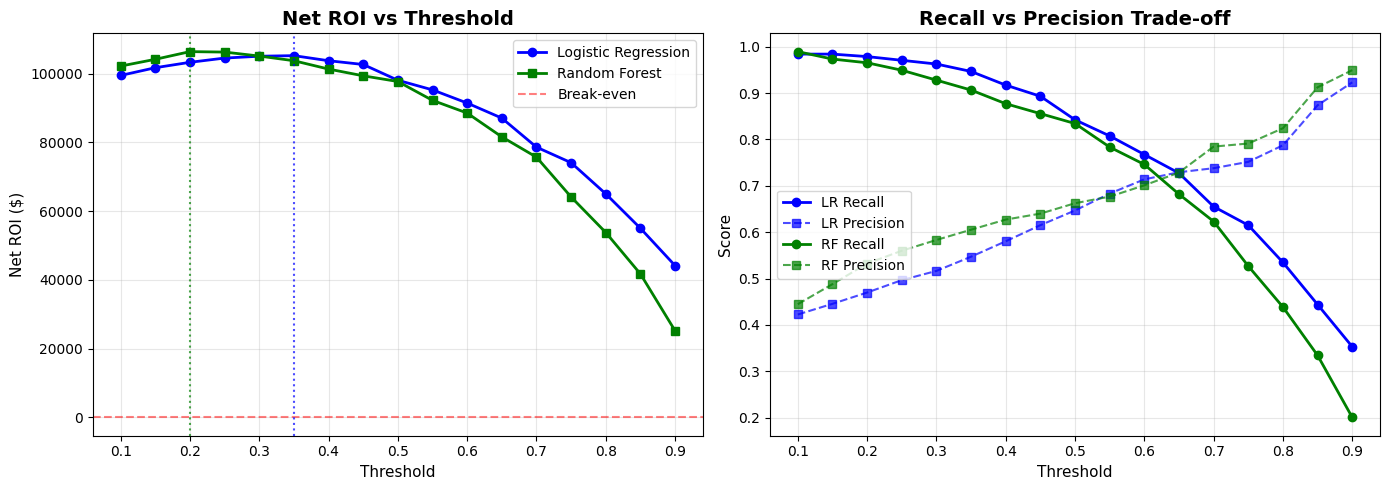

In [13]:
# Visualize ROI across thresholds
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROI Comparison
axes[0].plot(lr_sweep['Threshold'], lr_sweep['Net_ROI'], 'b-o', label='Logistic Regression', linewidth=2, markersize=6)
axes[0].plot(rf_sweep['Threshold'], rf_sweep['Net_ROI'], 'g-s', label='Random Forest', linewidth=2, markersize=6)
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Break-even')
axes[0].axvline(x=lr_optimal['Threshold'], color='b', linestyle=':', alpha=0.7)
axes[0].axvline(x=rf_optimal['Threshold'], color='g', linestyle=':', alpha=0.7)
axes[0].set_xlabel('Threshold', fontsize=11)
axes[0].set_ylabel('Net ROI ($)', fontsize=11)
axes[0].set_title('Net ROI vs Threshold', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Recall vs Precision trade-off
axes[1].plot(lr_sweep['Threshold'], lr_sweep['Recall'], 'b-o', label='LR Recall', linewidth=2)
axes[1].plot(lr_sweep['Threshold'], lr_sweep['Precision'], 'b--s', label='LR Precision', alpha=0.7)
axes[1].plot(rf_sweep['Threshold'], rf_sweep['Recall'], 'g-o', label='RF Recall', linewidth=2)
axes[1].plot(rf_sweep['Threshold'], rf_sweep['Precision'], 'g--s', label='RF Precision', alpha=0.7)
axes[1].set_xlabel('Threshold', fontsize=11)
axes[1].set_ylabel('Score', fontsize=11)
axes[1].set_title('Recall vs Precision Trade-off', fontsize=14, fontweight='bold')
axes[1].legend(loc='center left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# MODEL SELECTION DECISION
print("\n🏆 MODEL SELECTION DECISION")
print("=" * 60)

if lr_optimal['Net_ROI'] > rf_optimal['Net_ROI']:
    best_model = 'Logistic Regression'
    best_threshold = lr_optimal['Threshold']
    best_roi = lr_optimal['Net_ROI']
    best_sweep = lr_sweep
    best_proba = lr_proba
else:
    best_model = 'Random Forest'
    best_threshold = rf_optimal['Threshold']
    best_roi = rf_optimal['Net_ROI']
    best_sweep = rf_sweep
    best_proba = rf_proba

print(f"\n✅ RECOMMENDED MODEL: {best_model}")
print(f"✅ OPTIMAL THRESHOLD: {best_threshold:.2f}")
print(f"✅ EXPECTED NET ROI: ${best_roi:,.2f}")

# Store for later use
BEST_MODEL = best_model
BEST_THRESHOLD = best_threshold


🏆 MODEL SELECTION DECISION

✅ RECOMMENDED MODEL: Random Forest
✅ OPTIMAL THRESHOLD: 0.20
✅ EXPECTED NET ROI: $106,373.83


---

## 6. Segment-Level ROI Analysis

**Key insight**: Same threshold may not be optimal for all customer segments.

In [15]:
# Define customer segments based on value
# Use MonthlyCharges as proxy for customer value

charge_median = df['MonthlyCharges'].median()

df_test['value_segment'] = np.where(
    df_test['MonthlyCharges'] >= charge_median,
    'High-Value',
    'Low-Value'
)

print("📊 CUSTOMER SEGMENTS")
print("=" * 50)
print(f"\nSegment threshold: ${charge_median:.2f}/month")
print(f"\nSegment distribution:")
print(df_test['value_segment'].value_counts())
print(f"\nChurn rate by segment:")
print(df_test.groupby('value_segment')['y_true'].mean().apply(lambda x: f"{x:.2%}"))

📊 CUSTOMER SEGMENTS

Segment threshold: $70.35/month

Segment distribution:
value_segment
Low-Value     723
High-Value    686
Name: count, dtype: int64

Churn rate by segment:
value_segment
High-Value    35.13%
Low-Value     18.40%
Name: y_true, dtype: object


In [16]:
# Calculate segment-specific CLV
high_value_clv = df_test[df_test['value_segment'] == 'High-Value']['MonthlyCharges'].mean() * avg_remaining_months
low_value_clv = df_test[df_test['value_segment'] == 'Low-Value']['MonthlyCharges'].mean() * avg_remaining_months

print(f"\n📊 SEGMENT-SPECIFIC CLV")
print(f"   High-Value CLV: ${high_value_clv:,.2f}")
print(f"   Low-Value CLV:  ${low_value_clv:,.2f}")


📊 SEGMENT-SPECIFIC CLV
   High-Value CLV: $2,163.92
   Low-Value CLV:  $944.37


In [17]:
def segment_threshold_analysis(df_segment, proba_col, segment_clv, thresholds):
    """
    Analyze threshold performance for a specific segment.
    """
    # Create segment-specific cost matrix
    segment_cost_matrix = COST_MATRIX.copy()
    segment_cost_matrix['CLV'] = segment_clv
    segment_cost_matrix['TP'] = (segment_clv * RETENTION_SUCCESS_RATE) - RETENTION_COST
    segment_cost_matrix['FN'] = -(segment_clv * RETENTION_SUCCESS_RATE)
    
    results = []
    for t in thresholds:
        metrics = calculate_business_metrics(
            df_segment['y_true'].values,
            df_segment[proba_col].values,
            t,
            segment_cost_matrix
        )
        results.append(metrics)
    
    return pd.DataFrame(results)

# Use the best model's probabilities
proba_col = 'lr_proba' if BEST_MODEL == 'Logistic Regression' else 'rf_proba'

# Analyze High-Value segment
high_value_df = df_test[df_test['value_segment'] == 'High-Value']
high_value_sweep = segment_threshold_analysis(high_value_df, proba_col, high_value_clv, thresholds)

# Analyze Low-Value segment
low_value_df = df_test[df_test['value_segment'] == 'Low-Value']
low_value_sweep = segment_threshold_analysis(low_value_df, proba_col, low_value_clv, thresholds)

print("✅ Segment analysis completed!")

✅ Segment analysis completed!


In [18]:
# Find optimal thresholds for each segment
high_value_optimal = high_value_sweep.loc[high_value_sweep['Net_ROI'].idxmax()]
low_value_optimal = low_value_sweep.loc[low_value_sweep['Net_ROI'].idxmax()]

print("🎯 SEGMENT-LEVEL OPTIMAL THRESHOLDS")
print("=" * 60)

print(f"\n📊 High-Value Customers (${charge_median:.0f}+/month):")
print(f"   Customers in segment: {len(high_value_df):,}")
print(f"   Optimal Threshold: {high_value_optimal['Threshold']:.2f}")
print(f"   Net ROI: ${high_value_optimal['Net_ROI']:,.2f}")
print(f"   Recall: {high_value_optimal['Recall']:.2%}")

print(f"\n📊 Low-Value Customers (<${charge_median:.0f}/month):")
print(f"   Customers in segment: {len(low_value_df):,}")
print(f"   Optimal Threshold: {low_value_optimal['Threshold']:.2f}")
print(f"   Net ROI: ${low_value_optimal['Net_ROI']:,.2f}")
print(f"   Recall: {low_value_optimal['Recall']:.2%}")

🎯 SEGMENT-LEVEL OPTIMAL THRESHOLDS

📊 High-Value Customers ($70+/month):
   Customers in segment: 686
   Optimal Threshold: 0.25
   Net ROI: $109,962.47
   Recall: 98.34%

📊 Low-Value Customers (<$70/month):
   Customers in segment: 723
   Optimal Threshold: 0.30
   Net ROI: $14,428.36
   Recall: 84.96%


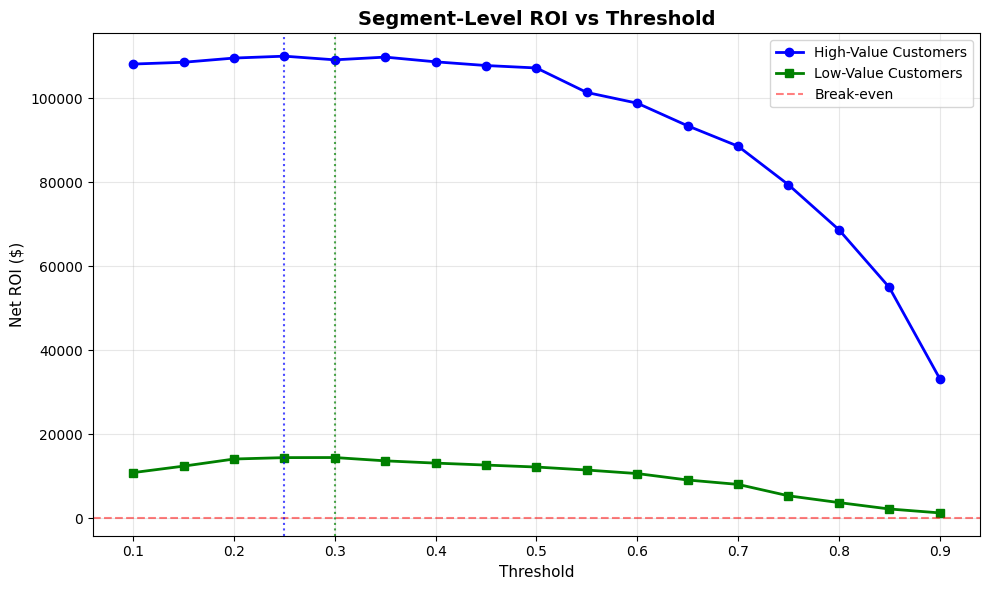

In [19]:
# Visualize segment-level ROI
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(high_value_sweep['Threshold'], high_value_sweep['Net_ROI'], 
        'b-o', label='High-Value Customers', linewidth=2, markersize=6)
ax.plot(low_value_sweep['Threshold'], low_value_sweep['Net_ROI'], 
        'g-s', label='Low-Value Customers', linewidth=2, markersize=6)

ax.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Break-even')
ax.axvline(x=high_value_optimal['Threshold'], color='b', linestyle=':', alpha=0.7)
ax.axvline(x=low_value_optimal['Threshold'], color='g', linestyle=':', alpha=0.7)

ax.set_xlabel('Threshold', fontsize=11)
ax.set_ylabel('Net ROI ($)', fontsize=11)
ax.set_title('Segment-Level ROI vs Threshold', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# KEY INSIGHT: Compare single threshold vs segment-specific thresholds
print("\n💡 KEY INSIGHT: Single vs Segment-Specific Thresholds")
print("=" * 60)

# Combined ROI using single threshold 
single_threshold_roi_high = high_value_sweep[high_value_sweep['Threshold'] == BEST_THRESHOLD]['Net_ROI'].values[0]
single_threshold_roi_low = low_value_sweep[low_value_sweep['Threshold'] == BEST_THRESHOLD]['Net_ROI'].values[0]
single_threshold_total = single_threshold_roi_high + single_threshold_roi_low

# Combined ROI using segment-specific thresholds
segment_threshold_total = high_value_optimal['Net_ROI'] + low_value_optimal['Net_ROI']

print(f"\n📊 Single Threshold ({BEST_THRESHOLD:.2f}) for all:")
print(f"   High-Value ROI: ${single_threshold_roi_high:,.2f}")
print(f"   Low-Value ROI:  ${single_threshold_roi_low:,.2f}")
print(f"   Total ROI:      ${single_threshold_total:,.2f}")

print(f"\n📊 Segment-Specific Thresholds:")
print(f"   High-Value ({high_value_optimal['Threshold']:.2f}): ${high_value_optimal['Net_ROI']:,.2f}")
print(f"   Low-Value ({low_value_optimal['Threshold']:.2f}):  ${low_value_optimal['Net_ROI']:,.2f}")
print(f"   Total ROI:      ${segment_threshold_total:,.2f}")

improvement = segment_threshold_total - single_threshold_total
print(f"\n🎯 IMPROVEMENT FROM SEGMENTATION: ${improvement:,.2f}")


💡 KEY INSIGHT: Single vs Segment-Specific Thresholds

📊 Single Threshold (0.20) for all:
   High-Value ROI: $109,512.47
   Low-Value ROI:  $14,075.37
   Total ROI:      $123,587.85

📊 Segment-Specific Thresholds:
   High-Value (0.25): $109,962.47
   Low-Value (0.30):  $14,428.36
   Total ROI:      $124,390.84

🎯 IMPROVEMENT FROM SEGMENTATION: $802.99


---

## 7. Final Recommendations

In [21]:
print("\n" + "=" * 70)
print("📊 BUSINESS IMPACT ANALYSIS - FINAL RECOMMENDATIONS")
print("=" * 70)

print(f"""
🏆 MODEL TO DEPLOY: {BEST_MODEL}

📊 THRESHOLD STRATEGY:

   Option A - Simple (Single Threshold):
   • Threshold: {BEST_THRESHOLD:.2f}
   • Expected ROI: ${best_roi:,.2f}
   • Easy to implement and explain

   Option B - Optimized (Segment-Specific):
   • High-Value Customers: Threshold {high_value_optimal['Threshold']:.2f}
   • Low-Value Customers: Threshold {low_value_optimal['Threshold']:.2f}
   • Expected ROI: ${segment_threshold_total:,.2f}
   • Additional value: ${improvement:,.2f}

💰 COST ASSUMPTIONS:
   • CLV (average): ${CLV:,.2f}
   • Retention Cost: ${RETENTION_COST:.2f}
   • Retention Success Rate: {RETENTION_SUCCESS_RATE:.0%}

📋 ACTION ITEMS:
   1. Validate cost assumptions with Finance
   2. Set up A/B test with control group
   3. Track actual retention success rate
   4. Re-calibrate thresholds monthly
""")


📊 BUSINESS IMPACT ANALYSIS - FINAL RECOMMENDATIONS

🏆 MODEL TO DEPLOY: Random Forest

📊 THRESHOLD STRATEGY:

   Option A - Simple (Single Threshold):
   • Threshold: 0.20
   • Expected ROI: $106,373.83
   • Easy to implement and explain

   Option B - Optimized (Segment-Specific):
   • High-Value Customers: Threshold 0.25
   • Low-Value Customers: Threshold 0.30
   • Expected ROI: $124,390.84
   • Additional value: $802.99

💰 COST ASSUMPTIONS:
   • CLV (average): $1,554.28
   • Retention Cost: $50.00
   • Retention Success Rate: 25%

📋 ACTION ITEMS:
   1. Validate cost assumptions with Finance
   2. Set up A/B test with control group
   3. Track actual retention success rate
   4. Re-calibrate thresholds monthly



In [22]:
# Create summary table for export
summary = pd.DataFrame({
    'Metric': [
        'Recommended Model',
        'Optimal Threshold (Single)',
        'Expected Net ROI (Single)',
        'High-Value Threshold',
        'Low-Value Threshold',
        'Expected Net ROI (Segmented)',
        'CLV (Average)',
        'Retention Cost',
        'Retention Success Rate'
    ],
    'Value': [
        BEST_MODEL,
        f"{BEST_THRESHOLD:.2f}",
        f"${best_roi:,.2f}",
        f"{high_value_optimal['Threshold']:.2f}",
        f"{low_value_optimal['Threshold']:.2f}",
        f"${segment_threshold_total:,.2f}",
        f"${CLV:,.2f}",
        f"${RETENTION_COST:.2f}",
        f"{RETENTION_SUCCESS_RATE:.0%}"
    ]
})

print("\n📊 SUMMARY TABLE")
print(summary.to_string(index=False))


📊 SUMMARY TABLE
                      Metric         Value
           Recommended Model Random Forest
  Optimal Threshold (Single)          0.20
   Expected Net ROI (Single)   $106,373.83
        High-Value Threshold          0.25
         Low-Value Threshold          0.30
Expected Net ROI (Segmented)   $124,390.84
               CLV (Average)     $1,554.28
              Retention Cost        $50.00
      Retention Success Rate           25%


In [23]:
# Save recommendations
import os

output_dir = '../reports'
os.makedirs(output_dir, exist_ok=True)

summary.to_csv(os.path.join(output_dir, 'business_recommendations.csv'), index=False)
lr_sweep.to_csv(os.path.join(output_dir, 'lr_threshold_sweep.csv'), index=False)
rf_sweep.to_csv(os.path.join(output_dir, 'rf_threshold_sweep.csv'), index=False)

print("✅ Reports saved to ../reports/")

✅ Reports saved to ../reports/


---

## 📝 Key Takeaways

1. **Model Selection**: Based on ROI, not just accuracy
2. **Threshold Matters**: Default 0.5 is rarely optimal for business
3. **Segment Strategy**: Different thresholds for different customer values
4. **Cost Sensitivity**: Results depend heavily on CLV and retention assumptions

---

*Notebook created: 2026-01-08*